In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import holidays

from calendar import day_name
from scipy.stats import skew
from sklearn import linear_model

plt.style.use('ggplot')
pd.set_option('display.max_rows', 20)

#### About the data sources

Hourly energy consumption (electricity) in the different price regions of Norway for 2013 - 2020 has been downloaded from Nord Pool: https://www.nordpoolgroup.com/historical-market-data/. The regions are illustrated below:

<img src="../../images/prisomraader.png" width="500px" />

Image from: https://energifaktanorge.no/?attachment_id=18082  
  
Additionally, hourly measured temperatures at Florida, Bergen has been downloaded via the MET Frost API: https://frost.met.no/index.html

### Load, merge and clean data 

#### Load consumption data

In [2]:
consumption_data_path = '../../data/NordPool/raw_data/consumption/'

In [3]:
os.listdir(consumption_data_path)

['.ipynb_checkpoints',
 'consumption-no-areas_2013_hourly.xls',
 'consumption-no-areas_2014_hourly.xls',
 'consumption-no-areas_2015_hourly.xls',
 'consumption-no-areas_2016_hourly.xls',
 'consumption-no-areas_2017_hourly.xls',
 'consumption-no-areas_2018_hourly.xls',
 'consumption-no-areas_2019_hourly.xls',
 'consumption-no-areas_2020_hourly.xls']

In [4]:
list_of_dfs = list()

for path in os.listdir(consumption_data_path):
    
    if path[-4:] == '.xls':
        
        print('Adding ' + path)

        df_current = pd.read_html(consumption_data_path + path)
        df_current = df_current[0]
        df_current.columns = df_current.columns.droplevel([0, 1])
        df_current['Datetime UTC+1'] = df_current['Unnamed: 0_level_2'] + ' ' + df_current.Hours.str[0:2] + ':00'
        df_current['Datetime UTC+1'] = pd.to_datetime(df_current['Datetime UTC+1'], format='%d-%m-%Y %H:%M')
        df_current.drop(['Unnamed: 0_level_2', 'Hours'], axis=1, inplace=True)
        cols = df_current.columns
        df_current = df_current[[cols[-1]] + cols[:-1].tolist()]

        list_of_dfs.append(df_current)
    
df_con = pd.concat(list_of_dfs, axis=0, ignore_index=True)

Adding consumption-no-areas_2013_hourly.xls
Adding consumption-no-areas_2014_hourly.xls
Adding consumption-no-areas_2015_hourly.xls
Adding consumption-no-areas_2016_hourly.xls
Adding consumption-no-areas_2017_hourly.xls
Adding consumption-no-areas_2018_hourly.xls
Adding consumption-no-areas_2019_hourly.xls
Adding consumption-no-areas_2020_hourly.xls


In [5]:
df_con.head()

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO
0,2013-01-01 00:00:00,4426.0,3920.0,2492.0,2152.0,1945.0,14934.0
1,2013-01-01 01:00:00,4350.0,3900.0,2400.0,2169.0,1927.0,14746.0
2,2013-01-01 02:00:00,4282.0,3833.0,2387.0,2171.0,1886.0,14559.0
3,2013-01-01 03:00:00,4180.0,3802.0,2357.0,2161.0,1894.0,14393.0
4,2013-01-01 04:00:00,4161.0,3833.0,2335.0,2187.0,1870.0,14385.0


#### Load measured temperature data

In [6]:
weather_data_path = '../../data/weather/florida/csv/'

list_of_dfs = list()

for path in os.listdir(weather_data_path):
    
    if path[-4:] == '.csv':
        df_current = pd.read_csv(weather_data_path + path, parse_dates=['referenceTime'])

        list_of_dfs.append(df_current)
    
df_weather = pd.concat(list_of_dfs, ignore_index=True)
df_weather['referenceTime UTC+1'] = df_weather['referenceTime'] + pd.Timedelta(hours=1) # Convert to UTC+1
df_weather.rename({'value': 'temperature'}, axis=1, inplace=True)

In [7]:
df_weather.head()

,referenceTime,sourceId,elementId,exposureCategory,level.levelType,level.unit,level.value,performanceCategory,qualityCode,timeOffset,timeResolution,timeSeriesId,unit,temperature,referenceTime UTC+1
0,2013-01-01 00:00:00,SN50540:0,air_temperature,2,height_above_ground,m,2,C,0,PT0H,PT1H,0,degC,6.0,2013-01-01 01:00:00
1,2013-01-01 01:00:00,SN50540:0,air_temperature,2,height_above_ground,m,2,C,0,PT0H,PT1H,0,degC,6.0,2013-01-01 02:00:00
2,2013-01-01 02:00:00,SN50540:0,air_temperature,2,height_above_ground,m,2,C,0,PT0H,PT1H,0,degC,5.5,2013-01-01 03:00:00
3,2013-01-01 03:00:00,SN50540:0,air_temperature,2,height_above_ground,m,2,C,0,PT0H,PT1H,0,degC,4.5,2013-01-01 04:00:00
4,2013-01-01 04:00:00,SN50540:0,air_temperature,2,height_above_ground,m,2,C,0,PT0H,PT1H,0,degC,3.9,2013-01-01 05:00:00


In [8]:
df_weather.shape

(67200, 15)

In [9]:
df_weather.referenceTime.nunique()

67200

#### Merge data

In [10]:
df_merged = pd.merge(left=df_con, right=df_weather[['referenceTime UTC+1', 'temperature']],
                     left_on='Datetime UTC+1', right_on='referenceTime UTC+1', how='left')

In [11]:
df_merged.head()

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,referenceTime UTC+1,temperature
0,2013-01-01 00:00:00,4426.0,3920.0,2492.0,2152.0,1945.0,14934.0,NaT,NaN
1,2013-01-01 01:00:00,4350.0,3900.0,2400.0,2169.0,1927.0,14746.0,2013-01-01 01:00:00,6.0
2,2013-01-01 02:00:00,4282.0,3833.0,2387.0,2171.0,1886.0,14559.0,2013-01-01 02:00:00,6.0
3,2013-01-01 03:00:00,4180.0,3802.0,2357.0,2161.0,1894.0,14393.0,2013-01-01 03:00:00,5.5
4,2013-01-01 04:00:00,4161.0,3833.0,2335.0,2187.0,1870.0,14385.0,2013-01-01 04:00:00,4.5


In [12]:
df_merged.drop('referenceTime UTC+1', axis=1, inplace=True)

#### Handle duplicate and missing data

Are there any duplicate timestamps?

In [13]:
df_merged[df_merged['Datetime UTC+1'].duplicated(keep=False)]

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature
7178,2013-10-27 02:00:00,2969.0,3134.0,2193.0,1783.0,1529.0,11609.0,11.1
7179,2013-10-27 02:00:00,2969.0,3134.0,2193.0,1783.0,1529.0,11609.0,11.1
15915,2014-10-26 02:00:00,2875.0,3216.0,2118.0,1708.0,1730.0,11647.0,11.3
15916,2014-10-26 02:00:00,2831.0,3183.0,2063.0,1695.0,1737.0,11508.0,11.3
24652,2015-10-25 02:00:00,3026.0,3231.0,2098.0,1681.0,1791.0,11828.0,6.7
24653,2015-10-25 02:00:00,2997.0,3195.0,2024.0,1635.0,1685.0,11535.0,6.7
33557,2016-10-30 02:00:00,3507.0,3458.0,2588.0,1923.0,1654.0,13131.0,7.0
33558,2016-10-30 02:00:00,3488.0,3443.0,2604.0,1890.0,1634.0,13060.0,7.0
42294,2017-10-29 02:00:00,3192.0,3583.0,2803.0,1926.0,1664.0,13168.0,6.9
42295,2017-10-29 02:00:00,3190.0,3586.0,2801.0,1893.0,1639.0,13108.0,6.9


Keep only the first sample

In [14]:
df_merged.drop_duplicates(subset='Datetime UTC+1', keep='first', inplace=True)

In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67368 entries, 0 to 67374
Data columns (total 8 columns):
Datetime UTC+1    67368 non-null datetime64[ns]
NO1               67342 non-null float64
NO2               67343 non-null float64
NO3               67343 non-null float64
NO4               67343 non-null float64
NO5               67343 non-null float64
NO                67343 non-null float64
temperature       67199 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 4.6 MB


What about missing values?

In [16]:
df_merged[df_merged.NO5.isna()].tail(30)

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature
2138,2013-03-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-2.4
10875,2014-03-30 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.1
19612,2015-03-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.4
28349,2016-03-27 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,8.9
37086,2017-03-26 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.7
45823,2018-03-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.3
54728,2019-03-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.6
63465,2020-03-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.5
67358,2020-09-07 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10.3
67359,2020-09-07 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10.5


In [17]:
# Remove last day, as there seems to be no data here
df_merged = df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-09-07 07:00')]

In [18]:
df_merged[df_merged.NO5.isna()].tail(30)

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature
2138,2013-03-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-2.4
10875,2014-03-30 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.1
19612,2015-03-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.4
28349,2016-03-27 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,8.9
37086,2017-03-26 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.7
45823,2018-03-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.3
54728,2019-03-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.6
63465,2020-03-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-0.5


In [19]:
df_merged[df_merged.temperature.isna()].head(40)

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature
0,2013-01-01 00:00:00,4426.0,3920.0,2492.0,2152.0,1945.0,14934.0,NaN
8738,2013-12-31 01:00:00,3974.0,3881.0,2371.0,2207.0,2046.0,14479.0,NaN
8739,2013-12-31 02:00:00,3864.0,3745.0,2305.0,2180.0,1997.0,14090.0,NaN
8740,2013-12-31 03:00:00,3820.0,3729.0,2292.0,2162.0,1983.0,13986.0,NaN
8741,2013-12-31 04:00:00,3815.0,3750.0,2301.0,2172.0,1970.0,14007.0,NaN
8742,2013-12-31 05:00:00,3876.0,3767.0,2330.0,2212.0,1997.0,14181.0,NaN
8743,2013-12-31 06:00:00,4061.0,3832.0,2361.0,2248.0,2043.0,14546.0,NaN
8744,2013-12-31 07:00:00,4242.0,3947.0,2428.0,2288.0,2125.0,15030.0,NaN
8745,2013-12-31 08:00:00,4441.0,4097.0,2501.0,2310.0,2225.0,15575.0,NaN
8746,2013-12-31 09:00:00,4637.0,4214.0,2536.0,2449.0,2226.0,16061.0,NaN


Fill missing consumption and temperature data with data from previous day

In [20]:
df_merged.sort_values(by='Datetime UTC+1', inplace=True)

columns_to_fill = ['NO1', 'NO2', 'NO3', 'NO4', 'NO5', 'NO', 'temperature']

# Loop through to fill oldest missing hours first
for row in df_merged[df_merged.isnull().any(axis=1)].iterrows():
    for col in columns_to_fill:
        if np.isnan(row[1][col]):
            try:
                df_merged.loc[row[0], col] = df_merged.loc[row[0] - 24, col]
            except Exception as e:
                print(type(e).__name__ + ' occurred:', e)
                print('Could not fill missing values for', col, '\n', row[1])
                continue

KeyError occurred: 'the label [-24] is not in the [index]'
Could not fill missing values for temperature 
 Datetime UTC+1    2013-01-01 00:00:00
NO1                              4426
NO2                              3920
NO3                              2492
NO4                              2152
NO5                              1945
NO                              14934
temperature                       NaN
Name: 0, dtype: object


In [21]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67351 entries, 0 to 67357
Data columns (total 8 columns):
Datetime UTC+1    67351 non-null datetime64[ns]
NO1               67351 non-null float64
NO2               67351 non-null float64
NO3               67351 non-null float64
NO4               67351 non-null float64
NO5               67351 non-null float64
NO                67351 non-null float64
temperature       67350 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 7.1 MB


In [22]:
df_merged[df_merged.NO5.isna()].head(30)

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature


In [23]:
df_merged[df_merged.temperature.isna()].head(30)

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature
0,2013-01-01,4426.0,3920.0,2492.0,2152.0,1945.0,14934.0,NaN


In [24]:
df_merged.drop(0, axis=0, inplace=True)
df_merged.reset_index(inplace=True, drop=True)

In [25]:
df_merged.head(5)

,Datetime UTC+1,NO1,NO2,NO3,NO4,NO5,NO,temperature
0,2013-01-01 01:00:00,4350.0,3900.0,2400.0,2169.0,1927.0,14746.0,6.0
1,2013-01-01 02:00:00,4282.0,3833.0,2387.0,2171.0,1886.0,14559.0,6.0
2,2013-01-01 03:00:00,4180.0,3802.0,2357.0,2161.0,1894.0,14393.0,5.5
3,2013-01-01 04:00:00,4161.0,3833.0,2335.0,2187.0,1870.0,14385.0,4.5
4,2013-01-01 05:00:00,4243.0,3858.0,2244.0,2177.0,1884.0,14405.0,3.9


In [26]:
df_merged.to_csv('../../data/NordPool/merged_data/consumption-no-areas_hourly_w_temperature.csv', index=False)

### Visualize and split data

#### Plot the time series

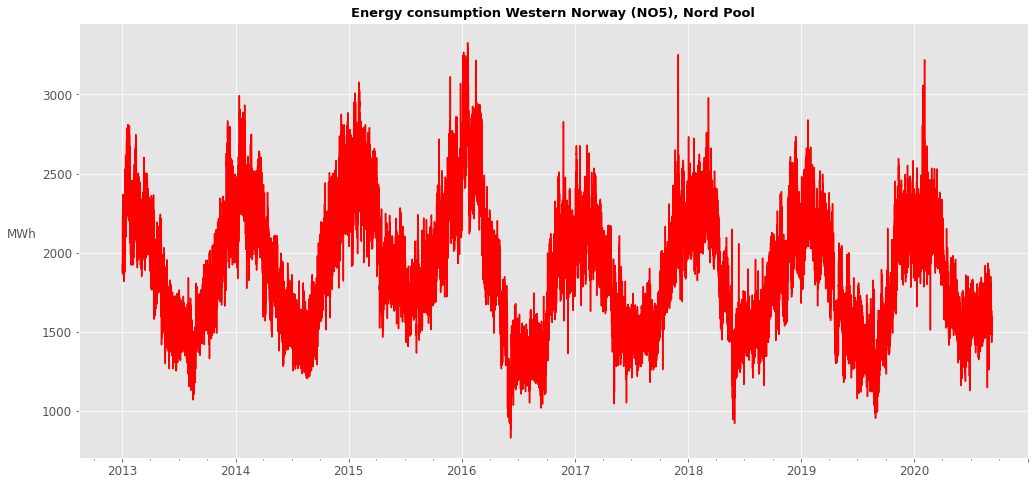

In [27]:
fig, ax = plt.subplots(figsize=(17, 8))
df_merged.plot(x='Datetime UTC+1', y='NO5', c='red', ax=ax, legend=None)
ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Energy consumption Western Norway (NO5), Nord Pool', fontsize=13, weight='bold')
ax.set_xlim([None, pd.Timestamp('2020-12-31 23:00')])
plt.show()

In [28]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_series_NO5.png', bbox_inches='tight')

#### Are there any trends in the data?

Fitting a line to a dataset is one way of estimating the linear trend in the data.

In [29]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].index.values.reshape(-1, 1),
             df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].NO5.values)

LinearRegression()

In [30]:
complete_fitted_line = lin_regr.predict(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].index.values.reshape(-1, 1))

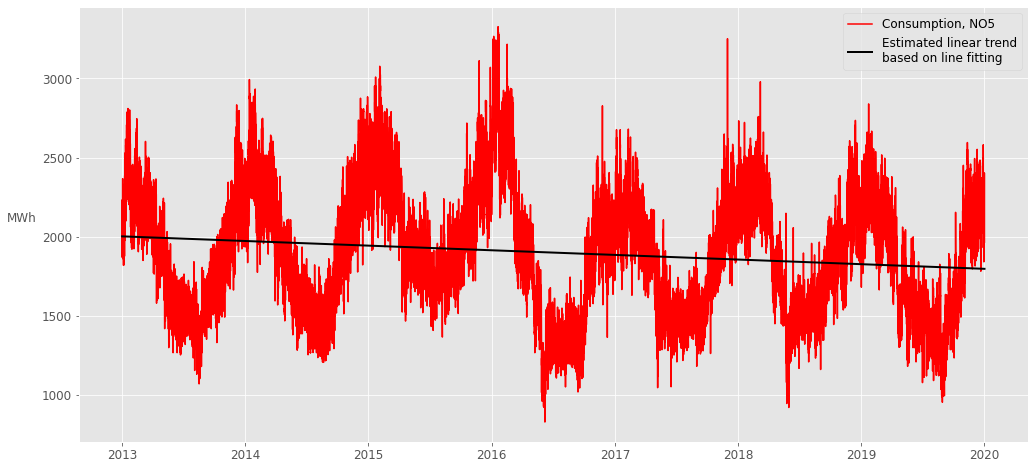

In [31]:
fig, ax = plt.subplots(figsize=(17, 8))
# df_merged.plot(x='Datetime UTC+1', y='NO5', c='red', ax=ax, label='Consumption, NO5')
ax.plot(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')]['Datetime UTC+1'],
        df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].NO5,  
        c='red', label='Consumption, NO5')
ax.plot(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')]['Datetime UTC+1'], complete_fitted_line, 
        c='k', lw=2, label='Estimated linear trend\nbased on line fitting')
ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [32]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_series_NO5_with_trend_complete.png', bbox_inches='tight')

In [33]:
print('Change in energy consumption (MWh) per year based on estimated linear trend:', round(lin_regr.coef_[0]*8760, 1))

Change in energy consumption (MWh) per year based on estimated linear trend: -29.3


Fitting a line to the data actually suggests that there is negative trend in energy consumption in the price region Western Norway (NO5). The fitted line suggests that the mean energy consumption has fallen 7 $\cdot$ 29.3 $\approx$ 205 MWh over the perriod 2013 - 2019. Can one observe a positive trend in temperature?

In [34]:
lin_regr_temp = linear_model.LinearRegression()
lin_regr_temp.fit(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].index.values.reshape(-1, 1),
             df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].temperature.values)

LinearRegression()

In [35]:
complete_fitted_line_temp = lin_regr_temp.predict(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].index.values.reshape(-1, 1))

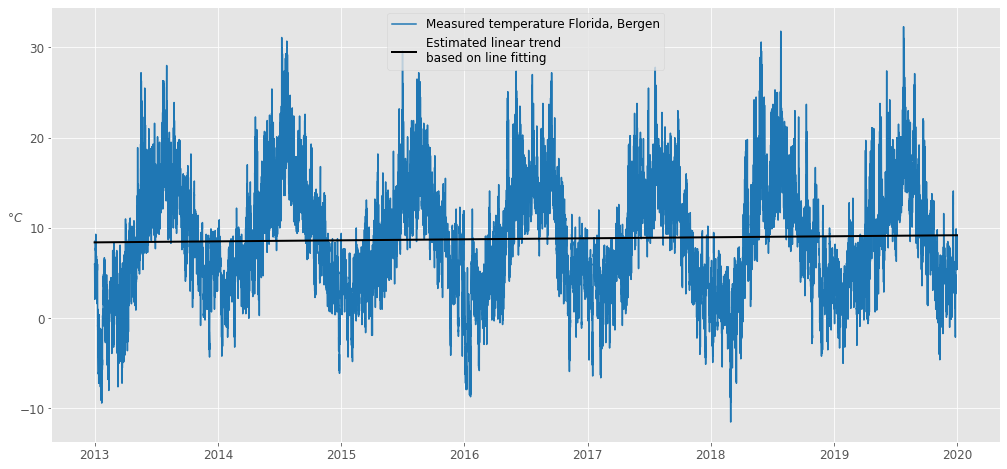

In [36]:
fig, ax = plt.subplots(figsize=(17, 8))
# df_merged.plot(x='Datetime UTC+1', y='NO5', c='red', ax=ax, label='Consumption, NO5')
ax.plot(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')]['Datetime UTC+1'],
        df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')].temperature,  
        c='tab:blue', label='Measured temperature Florida, Bergen')
ax.plot(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00')]['Datetime UTC+1'], complete_fitted_line_temp, 
        c='k', lw=2, label='Estimated linear trend\nbased on line fitting')
ax.set_xlabel('')
ax.set_ylabel(r'$\degree{C}$', fontsize=12, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [37]:
fig.savefig('../../plots/NordPool/eda_and_prep/temperature_series_with_trend_complete.png', bbox_inches='tight')

In [38]:
print('Change in temperature (degress celsius) per year based on estimated linear trend:', round(lin_regr_temp.coef_[0]*8760, 4))

Change in temperature (degress celsius) per year based on estimated linear trend: 0.1127


We observe an indication that there is a positive trend in the temperature data. Using this, one could estimate that the average temperature has risen by 7 $\cdot$ 0.1127 $\approx$ 0.79 degress celsius over the period 2013 - 2019.  

Looking at the consumption data it seems that there was a positive trend during 2013, 2014 and 2015. Additionally, the consumption during 2016 goes from a rather high level to what seems a normal level. If we split the data based on this, we get:

In [39]:
lin_regr_1 = linear_model.LinearRegression()
lin_regr_1.fit(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2016-01-01 00:00')].index.values.reshape(-1, 1), 
               df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2016-01-01 00:00')].NO5.values)

LinearRegression()

In [40]:
fitted_line_1 = lin_regr_1.predict(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2016-01-01 00:00')].index.values.reshape(-1, 1))

In [41]:
lin_regr_2 = linear_model.LinearRegression()
lin_regr_2.fit(df_merged[(df_merged['Datetime UTC+1'] >= pd.Timestamp('2017-01-01 00:00')) & 
                         (df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00'))].index.values.reshape(-1, 1), 
               df_merged[(df_merged['Datetime UTC+1'] >= pd.Timestamp('2017-01-01 00:00')) & 
                         (df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00'))].NO5.values)

LinearRegression()

In [42]:
fitted_line_2 = lin_regr_2.predict(df_merged[(df_merged['Datetime UTC+1'] >= pd.Timestamp('2017-01-01 00:00')) & 
                                             (df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00'))].index.values.reshape(-1, 1))

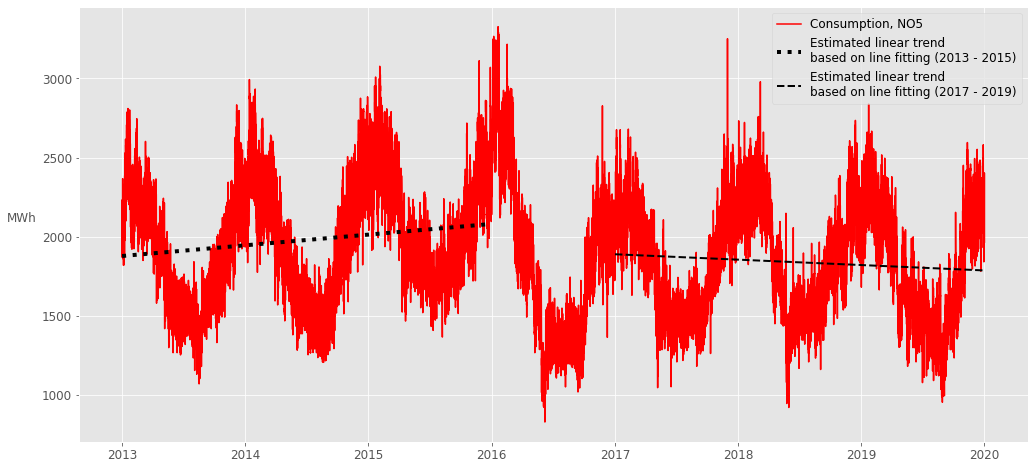

In [43]:
fig, ax = plt.subplots(figsize=(17, 8))
# df_merged.plot(x='Datetime UTC+1', y='NO5', c='red', ax=ax, label='Consumption, NO5')
ax.plot(df_merged[(df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00'))]['Datetime UTC+1'],
        df_merged[(df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00'))].NO5,  c='red', label='Consumption, NO5')
ax.plot(df_merged[df_merged['Datetime UTC+1'] < pd.Timestamp('2016-01-01 00:00')]['Datetime UTC+1'], fitted_line_1,
        'k:', lw=4, label='Estimated linear trend\nbased on line fitting (2013 - 2015)')
ax.plot(df_merged[(df_merged['Datetime UTC+1'] >= pd.Timestamp('2017-01-01 00:00')) & 
                  (df_merged['Datetime UTC+1'] < pd.Timestamp('2020-01-01 00:00'))]['Datetime UTC+1'], fitted_line_2,
        'k--', lw=2, label='Estimated linear trend\nbased on line fitting (2017 - 2019)')

ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [44]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_series_NO5_with_trend_split.png', bbox_inches='tight')

As observed, there seems the have been a positive trend in energy consumption during 2013, 2014 and 2015. After this there seems to exist a somewhat negative trend, indicating 2016 could be a turning point for energy consumption in the price region NO5. <br /><br /> 

Summarized, there seems to be a small negative trend in the energy consumption data, which mainly comes from the last 3-4 years of consumption.

#### Split into train and test set

Here, we will use the first 6 years of data as training data, and 2019 as the test set. Using an entire year as test data makes sure we are not testing on only a subset of possible situations like different seasons and holidays. Data from 2020 will not be used in any model training or testing.

In [45]:
train_test_date_split = pd.Timestamp('2019-01-01 00:00')
test_not_used_split = pd.Timestamp('2020-01-01 00:00')

df_train = df_merged[df_merged['Datetime UTC+1'] < train_test_date_split].copy()
df_test = df_merged[(df_merged['Datetime UTC+1'] >= train_test_date_split) & 
                    (df_merged['Datetime UTC+1'] < test_not_used_split)].copy()
df_2020 = df_merged[df_merged['Datetime UTC+1'] >= test_not_used_split].copy()

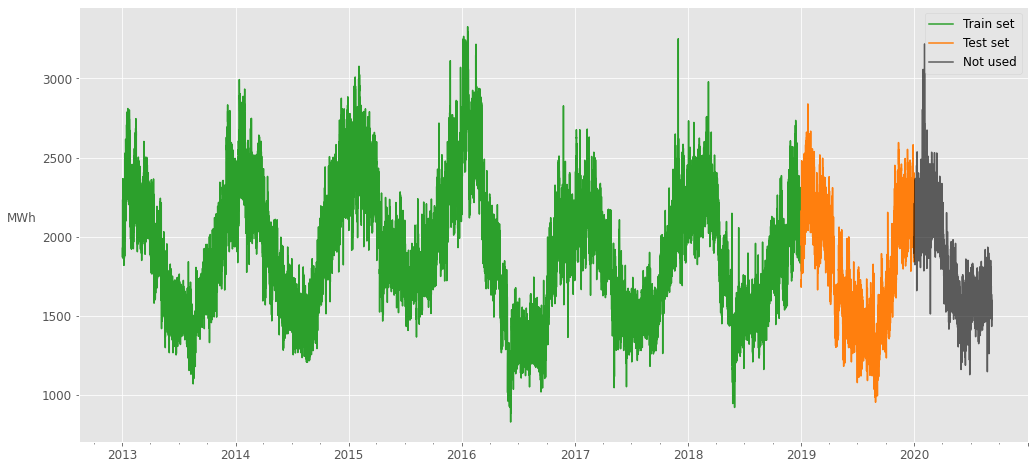

In [46]:
fig, ax = plt.subplots(figsize=(17, 8))

df_train.plot(x='Datetime UTC+1', y='NO5', c='tab:green', ax=ax, label='Train set')
df_test.plot(x='Datetime UTC+1', y='NO5', c='tab:orange', ax=ax, label='Test set')
df_2020.plot(x='Datetime UTC+1', y='NO5', c='k', ax=ax, alpha=0.6, label='Not used')

ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([None, pd.Timestamp('2020-12-31 23:00')])
ax.legend(fontsize=12)

plt.show()

In [47]:
fig.savefig('../../plots/NordPool/eda_and_prep/train_test_split.png', bbox_inches='tight')

In [48]:
df_train.to_csv('../../data/NordPool/merged_data/train_set.csv', index=False)
df_test.to_csv('../../data/NordPool/merged_data/test_set.csv', index=False)

### Explore the train set

#### Distribution of consumption

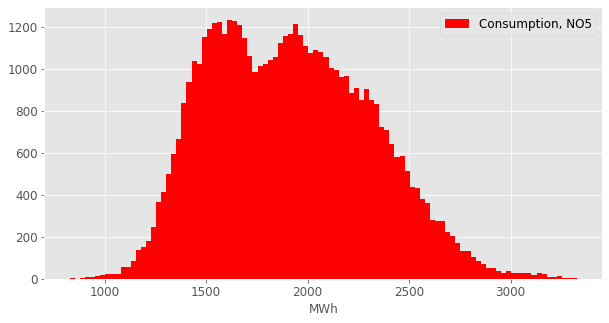

In [49]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_train['NO5'], bins=100, color='red', label='Consumption, NO5')
ax.set_xlabel('MWh', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
plt.show()

In [50]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_distribution_NO5.png', bbox_inches='tight')

In [51]:
print('Skewness of distribution:', round(skew(df_merged['NO5']), 3))

Skewness of distribution: 0.335


We observe a peak in consumption just above 1500 MWh. The distribution isn't  heavily skewed, so we probably do not need to apply any model independent transformations to this target variable.

#### Which consumption data points could be considered outliers?

Since the data source seems very reliable and the fact that (some version) of this data has been used for billing energy consumers, there should not be any chance of metering errors in the data set. Therefore, we will not remove any data based on what could seem to be an outlier. <br /><br /> But, for the sake of illustration, we will look at some approaches to how outliers could have been identified and then removed. One way of classifying a data point as an outlier or not is using z-scores. For example, we can set the limit at a z-score of +/- 3, which seems to be a popular rule of thumb/heuristic. If we use the entire train set for reference in calcualating the sample mean and standard deviation, we get:

In [52]:
df_train['z-score NO5'] = (df_train['NO5'] - df_train['NO5'].mean()) / df_train['NO5'].std(ddof=1)

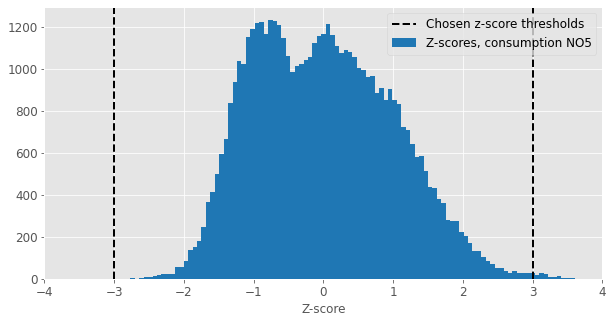

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_train['z-score NO5'], bins=100, color='tab:blue', label='Z-scores, consumption NO5')
ax.set_xlabel('Z-score', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(3, color='k', ls='--', lw=2, label='Chosen z-score thresholds')
ax.axvline(-3, color='k', ls='--', lw=2)
ax.legend(fontsize=12)
ax.set_xlim([-4, 4])
plt.show()

In [54]:
fig.savefig('../../plots/NordPool/eda_and_prep/z-score_distribution_NO5_complete_train_set.png', bbox_inches='tight')

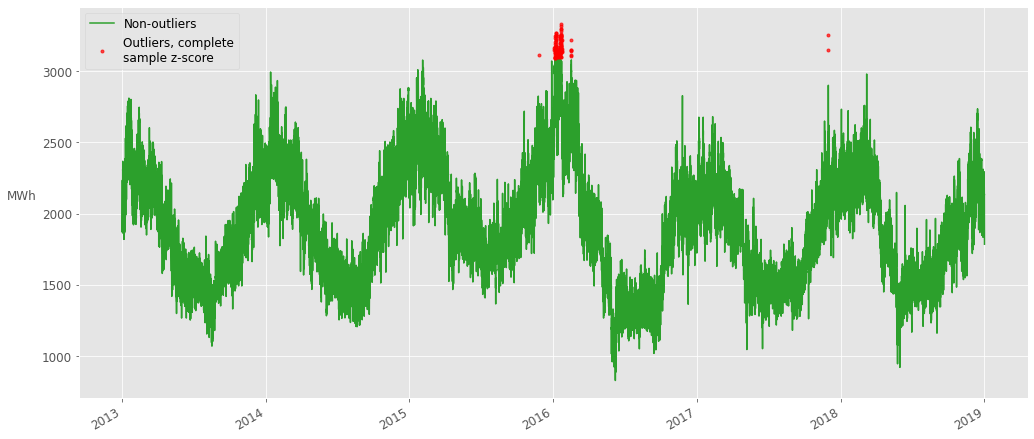

In [55]:
fig, ax = plt.subplots(figsize=(17, 8))

df_train[df_train['z-score NO5'] < 3].plot(x='Datetime UTC+1', y='NO5', c='tab:green', ax=ax, label='Non-outliers')
df_train[df_train['z-score NO5'] >= 3].plot(x='Datetime UTC+1', y='NO5', c='r', style='o', markersize=3, alpha=0.7, ax=ax, label='Outliers, complete\nsample z-score')

ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12, loc=2)

plt.show()

In [56]:
fig.savefig('../../plots/NordPool/eda_and_prep/outliers_z-scores_complete_train_set.png', bbox_inches='tight')

Alternatively, one can use moving z-scores. For example, using a centered rolling window of two month, the mean and standard deviation will be calculated over about 60 * 24 = 1440 data points

In [57]:
df_train['rolling z-score NO5'] = df_train['NO5'].rolling(window=61, center=True).apply(lambda x: (x[30] - x.mean()) / x.std(), raw=True)

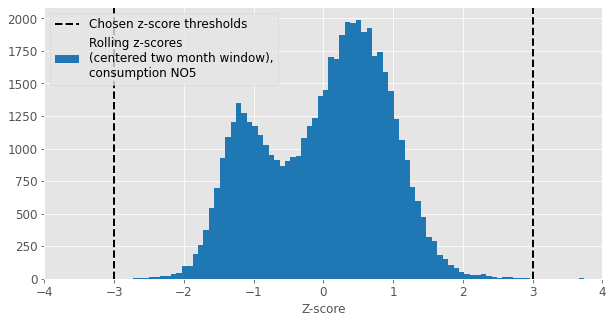

In [63]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_train['rolling z-score NO5'], bins=100, color='tab:blue', label='Rolling z-scores\n(centered two month window),\nconsumption NO5')
ax.set_xlabel('Z-score', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axvline(3, color='k', ls='--', lw=2, label='Chosen z-score thresholds')
ax.axvline(-3, color='k', ls='--', lw=2)
ax.legend(fontsize=12)
ax.set_xlim([-4, 4])
plt.show()

In [59]:
fig.savefig('../../plots/NordPool/eda_and_prep/z-score_rolling_distribution_NO5_train_set.png', bbox_inches='tight')

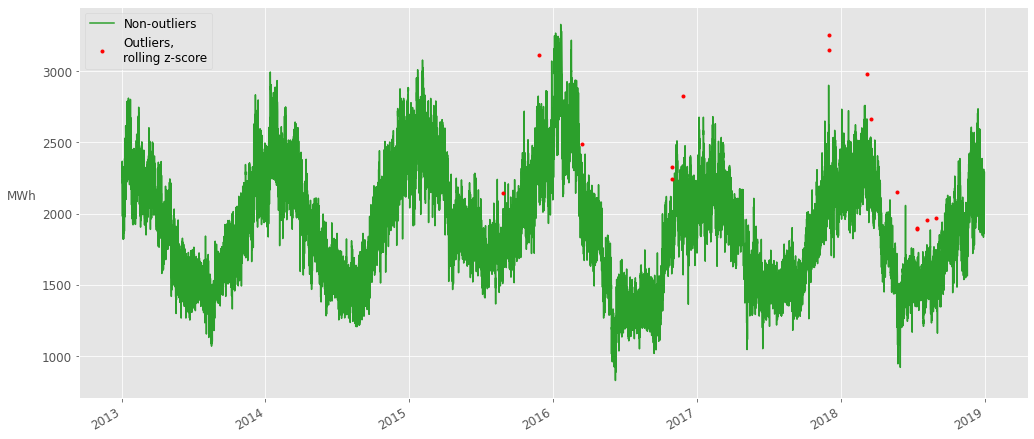

In [60]:
fig, ax = plt.subplots(figsize=(17, 8))

df_train[df_train['rolling z-score NO5'] < 3].plot(x='Datetime UTC+1', y='NO5', c='tab:green', ax=ax, label='Non-outliers')
df_train[df_train['rolling z-score NO5'] >= 3].plot(x='Datetime UTC+1', y='NO5', c='r', style='o', markersize=3, alpha=1, ax=ax, label='Outliers,\nrolling z-score')

ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12, loc=2)

plt.show()

In [61]:
fig.savefig('../../plots/NordPool/eda_and_prep/outliers_rolling_z-scores_train_set.png', bbox_inches='tight')

Using a rolling window gives entirely different results. If one actually were to remove outliers from this data, one should should experiment with the window size, look at other outlier detection approaches etc, but this will not be done here.

#### Hourly averages for weekdays and weekends

In [64]:
df_agg_hours = df_train.groupby(df_train['Datetime UTC+1'].dt.hour).mean()
df_agg_hours_weekday = df_train[~df_train['Datetime UTC+1'].dt.weekday.isin([5, 6])]. \
    groupby(df_train['Datetime UTC+1'].dt.hour).mean()
df_agg_hours_weekend = df_train[df_train['Datetime UTC+1'].dt.weekday.isin([5, 6])]. \
    groupby(df_train['Datetime UTC+1'].dt.hour).mean()

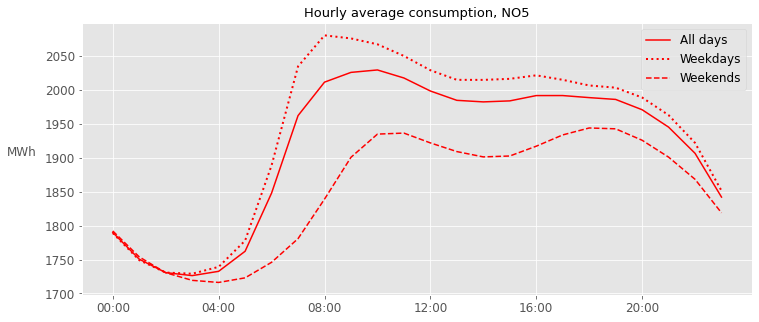

In [65]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title('Hourly average consumption, NO5', fontsize=13)
df_agg_hours.plot(y='NO5', ax=ax, style='r-', label='All days')
df_agg_hours_weekday.plot(y='NO5', ax=ax, style='r:', lw=2, label='Weekdays')
df_agg_hours_weekend.plot(y='NO5', ax=ax, style='r--', label='Weekends')
ax.set_xlabel('')
ax.legend(fontsize=12)
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_label_coords(-0.09, 0.5)
ax.set_xticks([0, 4, 8, 12, 16, 20])
ax.set_xticklabels(['00:00', '04:00', '08:00', '12:00', '16:00', '20:00'])
plt.show()

In [84]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_hourly_avgs_NO5.png', bbox_inches='tight')

The consumption is also shifted during weekends, with the morning peak occurring at around 11:00 instead around 09:00 as on weekdays. Likewise, the afternoon peak occurs at around 16:00 during weekdays and is shifted to around 19:00 on weekends. Less consumption in the weekends indicates a fair share of industry consumers. A feature indicating if we have a weekday or not should be inculded.

#### Hourly averages, each day of week

Does hourly average consumption change with each day of the week? If so, using weekday as a feature later would be beneficial

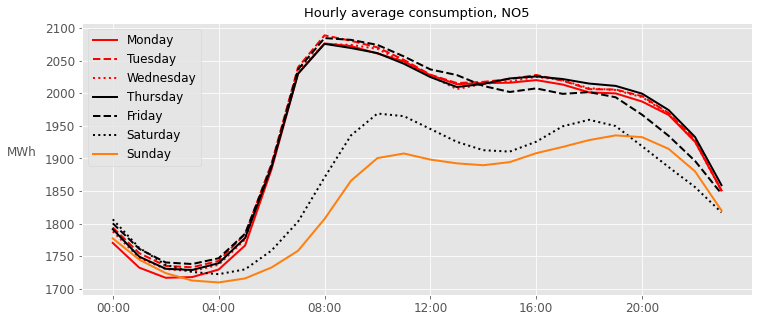

In [79]:
styles = ['r', 'r--', 'r:', 'k', 'k--', 'k:', 'tab:orange']

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title('Hourly average consumption, NO5', fontsize=13)

for day_nr in range(0, 7):
    df_agg_hours_current_weekday = df_train[df_train['Datetime UTC+1'].dt.weekday == day_nr]. \
        groupby(df_train['Datetime UTC+1'].dt.hour).mean()

    df_agg_hours_current_weekday.plot(y='NO5', ax=ax, style=styles[day_nr], lw=2, label=day_name[day_nr])


ax.set_xlabel('')
ax.legend(fontsize=12)
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_label_coords(-0.09, 0.5)
ax.set_xticks([0, 4, 8, 12, 16, 20])
ax.set_xticklabels(['00:00', '04:00', '08:00', '12:00', '16:00', '20:00'])

plt.show()

In [80]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_hourly_avgs_NO5_each_dayofweek.png', bbox_inches='tight')

We observe that there is no big difference in consumption within the weekdays, but that there is a difference between saturday and sunday. Separating these two days using relevant features might be a good idea.

#### Can we see indications of COVID-19 in the energy consumption data?

In [66]:
df_agg_hours_weekday_not_2020 = df_train[(df_train['Datetime UTC+1'].dt.month.isin([3, 4, 5, 6, 7, 8])) &
                                         (~df_train['Datetime UTC+1'].dt.weekday.isin([5, 6]))].groupby(df_train['Datetime UTC+1'].dt.hour).mean()
df_agg_hours_weekend_not_2020 = df_train[(df_train['Datetime UTC+1'].dt.month.isin([3, 4, 5, 6, 7, 8])) & 
                                         (df_train['Datetime UTC+1'].dt.weekday.isin([5, 6]))].groupby(df_train['Datetime UTC+1'].dt.hour).mean()

In [67]:
df_agg_hours_weekday_2020 = df_2020[(df_2020['Datetime UTC+1'].dt.month.isin([3, 4, 5, 6, 7, 8])) &
                                    (~df_2020['Datetime UTC+1'].dt.weekday.isin([5, 6]))].groupby(df_2020['Datetime UTC+1'].dt.hour).mean()
df_agg_hours_weekend_2020 = df_2020[(df_2020['Datetime UTC+1'].dt.month.isin([3, 4, 5, 6, 7, 8])) & 
                                    (df_2020['Datetime UTC+1'].dt.weekday.isin([5, 6]))].groupby(df_2020['Datetime UTC+1'].dt.hour).mean()

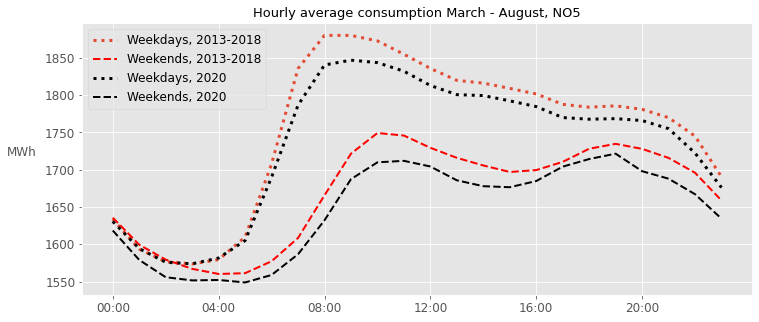

In [69]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title('Hourly average consumption March - August, NO5', fontsize=13)
df_agg_hours_weekday_not_2020.plot(y='NO5', ax=ax, style=':', lw=3, label='Weekdays, 2013-2018')
df_agg_hours_weekend_not_2020.plot(y='NO5', ax=ax, style='r--', lw=2, label='Weekends, 2013-2018')
df_agg_hours_weekday_2020.plot(y='NO5', ax=ax, c='k', style=':', lw=3, label='Weekdays, 2020')
df_agg_hours_weekend_2020.plot(y='NO5', ax=ax, c='k', style='--', lw=2, label='Weekends, 2020')
ax.set_xlabel('')
ax.legend(fontsize=12)
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_label_coords(-0.09, 0.5)
ax.set_xticks([0, 4, 8, 12, 16, 20])
ax.set_xticklabels(['00:00', '04:00', '08:00', '12:00', '16:00', '20:00'])
plt.show()

In [70]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_hourly_avgs_NO5_2020_comparison.png', bbox_inches='tight')

On weekdays, the consumption seems to be pretty much matching during the night, but the morning peak is a little less pronounced in 2020, as well as the afternoon weekday consumption. The consumption during weekends seems to be lower during the entire day.<br /><br />
The lower consumption during weekdays could be the result of for example industries shutting down/moving, increased energy efficiency, a change in consumer patterns caused by a large number of people working remotely etc. Therefore, it is difficult to conclude anything from this aggregated data. If one had data for smaller regions, for example for all consumer under a secondary substation/transformer, one could probably reveal changes in consumer patterns after the COVID-19 outbreak. For example, the consumption patterns in cabin areas probably changed after many were forced to work from home.

#### Consumption during holidays

In [90]:
nor_holidays = holidays.NO(years=range(2013, 2019))

In [98]:
set(nor_holidays.values())

{'Andre juledag',
 'Andre pinsedag',
 'Andre påskedag',
 'Arbeidernes dag',
 'Arbeidernes dag, Søndag',
 'Første juledag',
 'Første juledag, Søndag',
 'Første nyttårsdag',
 'Første nyttårsdag, Søndag',
 'Første pinsedag, Søndag',
 'Første påskedag, Søndag',
 'Grunnlovsdag',
 'Grunnlovsdag, Søndag',
 'Kristi himmelfartsdag',
 'Langfredag',
 'Skjærtorsdag',
 'Søndag'}

In [107]:
# Remove sundays (søndag)
holiday_dict = dict()
for date, holiday_name in nor_holidays.items():
    if holiday_name != 'Søndag':
        holiday_dict[date] = holiday_name

In [124]:
df_agg_hours_holidays = df_train[df_train['Datetime UTC+1'].dt.date.isin(holiday_dict.keys())].groupby(df_train['Datetime UTC+1'].dt.hour).mean()
df_agg_hours_non_holidays = df_train[~df_train['Datetime UTC+1'].dt.date.isin(holiday_dict.keys())].groupby(df_train['Datetime UTC+1'].dt.hour).mean()

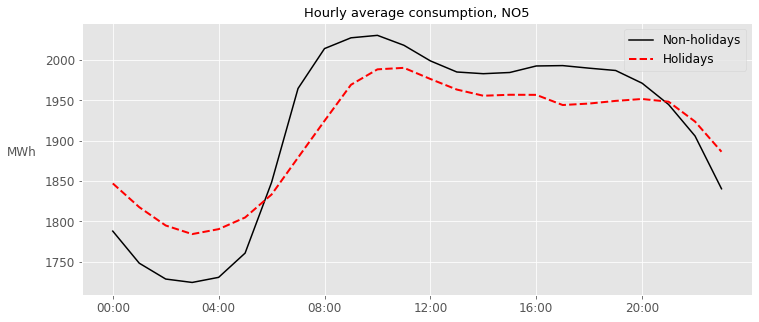

In [215]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title('Hourly average consumption, NO5', fontsize=13)
df_agg_hours_non_holidays.plot(y='NO5', ax=ax, style='k', label='Non-holidays')
df_agg_hours_holidays.plot(y='NO5', ax=ax, style='r--', lw=2, label='Holidays')
ax.set_xlabel('')
ax.legend(fontsize=12)
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.set_label_coords(-0.09, 0.5)
ax.set_xticks([0, 4, 8, 12, 16, 20])
ax.set_xticklabels(['00:00', '04:00', '08:00', '12:00', '16:00', '20:00'])
plt.show()

In [216]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_hourly_avgs_NO5_holidays.png', bbox_inches='tight')

Holidays seem to be characterized by a higher level of consumption during the late evening and night and a generally lower consuption during the day. Also, the rise in consumption during morning hours is shifted to later hours, like observed for weekends above. Including a holiday feature during modelling seems like a good idea.

#### Plot consumption and temperature

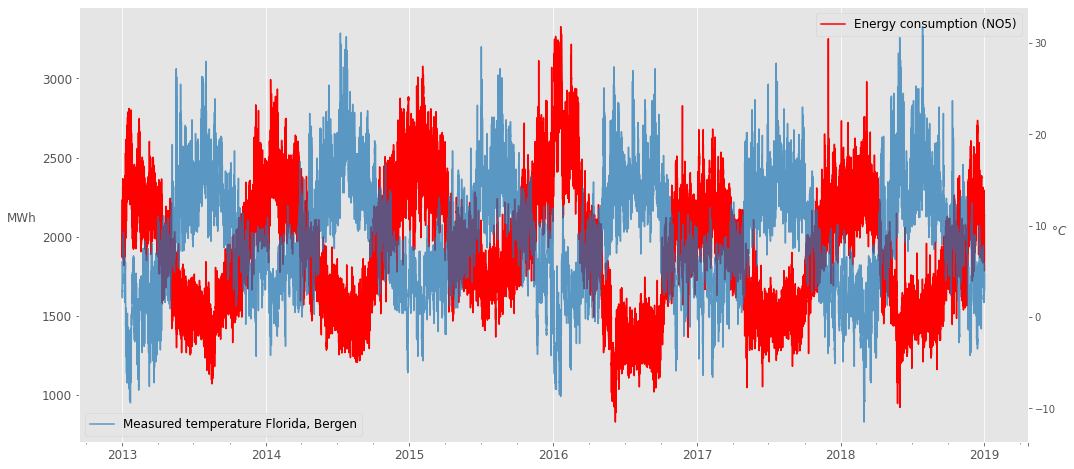

In [129]:
fig, ax = plt.subplots(figsize=(17, 8))

ax2 = ax.twinx()
df_train.plot(x='Datetime UTC+1', y='NO5', ax=ax, c='r', label='Energy consumption (NO5)', alpha=1)
df_train.plot(x='Datetime UTC+1', y='temperature', ax=ax2, c='tab:blue', label='Measured temperature Florida, Bergen', alpha=0.7)

ax.set_xlabel('')
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.06, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y')

ax2.set_ylabel(r'$\degree{C}$', fontsize=12, rotation=0)
ax2.legend(fontsize=12)
ax2.grid(False)

plt.show()

In [130]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_series_NO5_with_temp.png', bbox_inches='tight')

#### Weekly means of consumption and temperature

In [131]:
df_agg_weeks = df_train.groupby(df_con['Datetime UTC+1'].dt.week).mean()

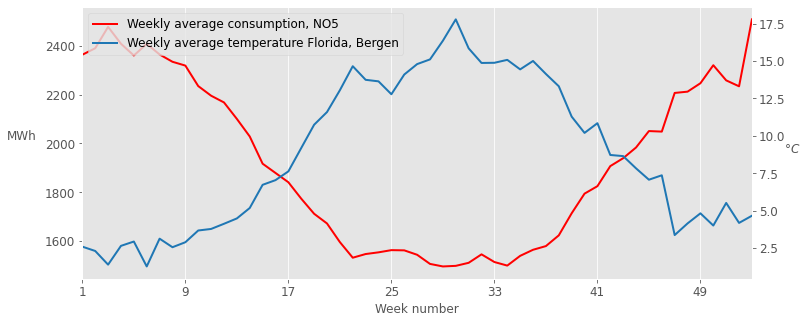

In [134]:
fig, ax = plt.subplots(figsize=(12, 5))

df_agg_weeks.plot(y='NO5', ax=ax, c='red', lw=2, label='Weekly average consumption, NO5')
df_agg_weeks.plot(y='temperature', secondary_y=True, ax=ax, c='tab:blue', lw=2, label='Weekly average temperature Florida, Bergen', legend=True)

ax.set_xlabel('Week number', fontsize=12)
ax.set_ylabel('MWh', fontsize=12, rotation=0)
ax.yaxis.set_label_coords(-0.09, 0.5)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(range(1, 61, 8))
ax.right_ax.set_xticks(range(1, 61, 8))
ax.set_xlim([1, 53])

ax.right_ax.yaxis.set_label_coords(1.05, 0.5)
ax.right_ax.tick_params(axis='both', which='major', labelsize=12)
ax.right_ax.set_ylabel(r'$\degree{C}$', rotation=0, fontsize=12)
ax.right_ax.yaxis.set_label_coords(1.06, 0.5)

lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper left', fontsize=12)

ax.grid(False)
ax.right_ax.grid(False)
ax.grid(axis='x')

plt.show()

In [135]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_weekly_avg_NO5_with_temp.png', bbox_inches='tight')

#### Plot temperature against consumption

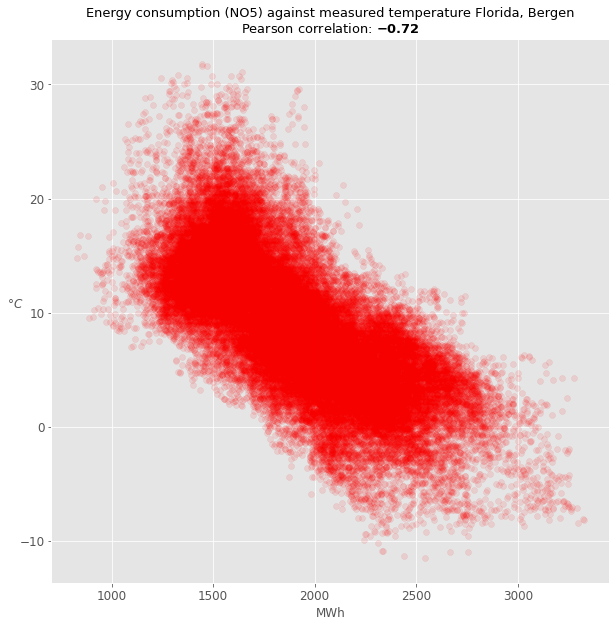

In [139]:
corr = round(df_train.NO5.corr(df_train.temperature, method='pearson'), 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_train.NO5, df_train.temperature, c='r', alpha=0.1)
ax.set_xlabel('MWh', fontsize=12)
ax.set_ylabel(r'$\degree{C}$', rotation=0, fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Energy consumption (NO5) against measured temperature Florida, Bergen' + \
             '\nPearson correlation: ' + r'$\bf{' + str(corr) + r'}$', fontsize=13)
plt.show()

In [140]:
fig.savefig('../../plots/NordPool/eda_and_prep/consumption_NO5_against_temp_bergen.png', bbox_inches='tight')

The least energy is consumed at temperatures around 15&deg;C, higher temperatures are probably resulting in energy being used for cooling